# Large scale text analysis with deep learning

In this assignment, you will develop a deep learning model to predict salaries based on resumes (credits to to [Oleg Vasilev](https://github.com/Omrigan/)). While we will begin this project during our seminar class, it will require additional effort on your part to finalize and submit it as homework.

Following this, there is a supplementary task in another notebook titled homework_part2.ipynb. In this task, you are expected to conduct a more extensive study. This will involve testing various architectures to optimize prediction accuracy.

To secure full marks for this assignment, ensure a consistent training process with an **MSE loss falling below 0.10**. If necessary, feel free to experiment with different parameters and model architectures. If you achieve the desired results in the homework_part2.ipynb, you can either replicate your solution here or reference it explicitly in the comments when you submit.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here].

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

### **Downloading**

In [ ]:
import requests
from urllib.parse import urlencode

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/vVEOWPFY3NruT7'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('Train_rev1.zip', 'wb') as f:
    f.write(download_response.content)

### **Unpacking!**

In [ ]:
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [ ]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons of money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

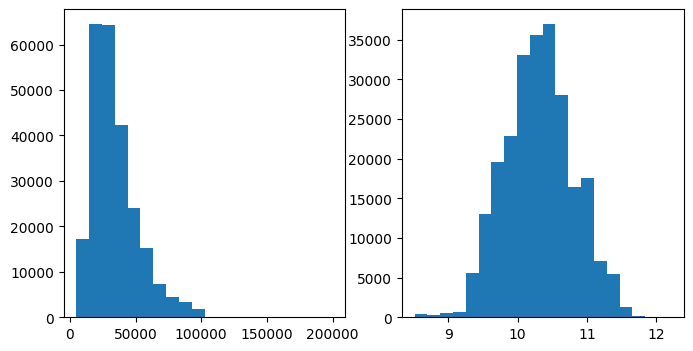

In [ ]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

<br>

To do so, our model can access a ***number of features***:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [ ]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
153256,70783131,Dynamics NAV Technical Consultant – Birmingham...,Dynamics NAV Technical Consultant – Birmingham...,Birmingham West Midlands (County) West Midlands,UK,NaN,permanent,Conspicuous,IT Jobs,"Up to 55,000 per annum",55000,cwjobs.co.uk,10.915107
156357,71091859,RGN Colwyn Bay,GREAT OPPORTUNITIES FOR REGISTERED NURSES Are ...,Colwyn Bay,Colwyn Bay,full_time,NaN,Jane Lewis Health & Social Care,Healthcare & Nursing Jobs,13.00 - 26.00/Hour,37440,staffnurse.com,10.530521
198837,71849158,Store Manager Designate,"Store Manager Designate 25K ****K Basic, Plu...",Leeds West Yorkshire Yorkshire,Leeds,NaN,permanent,PerfectHome,Accounting & Finance Jobs,25k - 35k per year,30000,totaljobs.com,10.308986


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [ ]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [ ]:
data[text_columns].head()

,Title,FullDescription
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do..."


In [ ]:
import nltk
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

for column in text_columns:
    data[column] = data[column].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))

In [ ]:
data[text_columns].head()

,Title,FullDescription
0,engineering systems analyst,engineering systems analyst dorking surrey sal...
1,stress engineer glasgow,stress engineer glasgow salary **** to **** we...
2,modelling and simulation analyst,mathematical modeller / simulation analyst / o...
3,engineering systems analyst / mathematical mod...,engineering systems analyst / mathematical mod...
4,"pioneer , miser engineering systems analyst","pioneer , miser engineering systems analyst do..."


Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
data['Title']

0                               engineering systems analyst
1                                   stress engineer glasgow
2                          modelling and simulation analyst
3         engineering systems analyst / mathematical mod...
4               pioneer , miser engineering systems analyst
                                ...                        
244763                                   teacher of science
244764                  teacher of business studies and ict
244765                                      english teacher
244766                                      supply teachers
244767                                           accountant
Name: Title, Length: 244768, dtype: object

In [ ]:
from collections import Counter
token_counts = Counter()

for column in text_columns:
    data[column].apply(lambda x: token_counts.update(tokenizer.tokenize(x)))

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


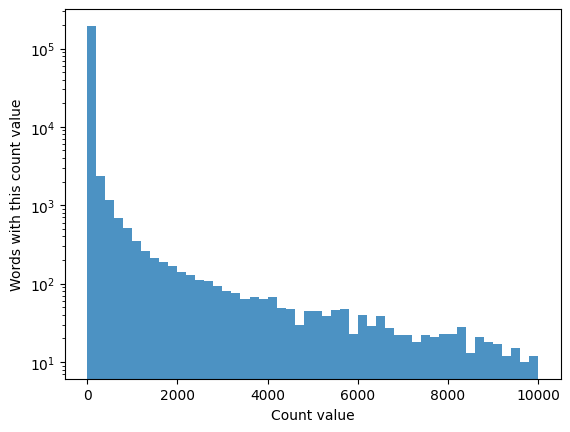

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True, alpha=0.8)
plt.xlabel("Count value");
plt.ylabel("Words with this count value");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
# PAD token is used to pad sequences to a fixed length
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens
tokens[1::10000]

['PAD', 'dunblane', 'mnes', 'suzanne']

In [ ]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token (string) to it's index in `tokens` (int)

In [ ]:
token_to_id = dict(zip(tokens, [i for i in range(len(tokens))]))

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

**Text columns** will be encoded using `as_matrix` function (preliminary step so that it would be easier to train NN further)

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):   # checks if the first element of the sequences list is of type str. If it is, it assumes that all elements in the list are strings
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [ ]:
categorical_columns

['Category', 'Company', 'LocationNormalized', 'ContractType', 'ContractTime']

**Categorical columns** will be encoded using `categorical_vectorizer`

In [ ]:
data[categorical_columns].head()

,Category,Company,LocationNormalized,ContractType,ContractTime
0,Engineering Jobs,Gregory Martin International,Dorking,NaN,permanent
1,Engineering Jobs,Gregory Martin International,Glasgow,NaN,permanent
2,Engineering Jobs,Gregory Martin International,Hampshire,NaN,permanent
3,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent
4,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent


In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    '''
    Word dropout is a technique used in natural language processing to randomly replace words in the input with a special token (such as <UNK>)
    to improve robustness and prevent overfitting
    '''
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
data_train[:3]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,69173058,senior support worker,senior support worker wanted a senior support ...,"Taunton, Somerset Somerset South West",Taunton,NaN,permanent,Other,Healthcare & Nursing Jobs,15931 - 17082 per annum,16506,totaljobs.com,9.711540
1,72450873,statistical / mathematical modeller in pharmac...,statistical / mathematical modeller in pharmac...,North West,North West London,NaN,permanent,Other,Scientific & QA Jobs,"From 30,000 to 40,000 per annum 30-40K",35000,totaljobs.com,10.463132
2,68364211,emc team leader ( def stan ),the opportunity my client is currently seeking...,Surrey,Surrey,NaN,permanent,Other,Engineering Jobs,45k + Bonus + Pension,45000,justengineers.net,10.714440


In [ ]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051],
         [10609, 30412, 17746,    33,  8705, 29157,    65]], device='cuda:0'),
 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451, 32939],
         [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,    82],
         [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412, 17746]],
        device='cuda:0'),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144], device='cuda:0')}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

### Little part about Embedding layer

#### General
`nn.Embedding(5, 2)` $-$ let's say that we have vocabulary of 5 words


*   `nn.Embedding` is a table with embeddings for those 5 vectors (each vector of size 2)
*   for each token with number i corresponding vector with such number is taken from the table
*   then those parameters are fine-tuned

In [ ]:
emb = nn.Embedding(5, 2)    # can train using this method

In [ ]:
emb.weight

Parameter containing:
tensor([[-0.1200,  0.4242],
        [-0.7719,  1.2051],
        [-0.6794, -0.8478],
        [ 0.1848, -0.6176],
        [-0.7493,  0.2073]], requires_grad=True)

In [ ]:
emb(torch.tensor([0, 2, 1]))

tensor([[-0.1200,  0.4242],
        [-0.6794, -0.8478],
        [-0.7719,  1.2051]], grad_fn=<EmbeddingBackward0>)

#### Our Case

In [ ]:
emb = torch.nn.Embedding(34_000, 32)            # 34_000 samples, 32 dim

In [ ]:
piece = make_batch(data_train[:3], max_len=10, device='cpu')
piece["Title"]

tensor([[27645, 29893, 33674,     1,     1,     1,     1],
        [29239,   197, 19175, 20042, 15554, 23162,  4051],
        [10609, 30412, 17746,    33,  8705, 29157,    65]])

In [ ]:
emb(piece["Title"]).shape

torch.Size([3, 7, 32])

In [ ]:
emb(piece["Title"])[0]  # 3 = batch_size

tensor([[ 1.5068e-01, -2.0209e+00, -2.7310e-01, -3.4801e-01,  8.9040e-01,
          9.8963e-01, -6.0834e-01,  6.4623e-01, -3.9155e-01,  1.2940e+00,
         -7.5606e-01, -5.9852e-01, -1.4822e+00,  3.0404e-01,  6.1407e-01,
         -2.1535e-01, -1.1904e+00,  6.8016e-01, -1.5398e+00,  1.0223e+00,
         -5.6138e-01, -2.0170e+00,  2.3591e+00, -1.3662e+00, -1.3339e+00,
          3.5948e-02, -2.0804e+00,  8.5171e-02, -5.0390e-01, -6.2759e-01,
         -3.7239e-01, -2.2305e+00],
        [-1.5801e-01, -2.8288e-02,  3.0334e-01,  2.9082e-01, -7.2184e-01,
         -1.0388e+00,  1.0530e+00,  1.6274e-01, -1.2029e+00,  2.2532e-01,
          3.2910e-01, -4.3561e-01,  1.7429e-01,  6.9288e-01,  2.7607e-01,
          1.0550e+00, -1.4394e+00, -9.4421e-01,  6.0288e-01,  1.1451e-01,
         -6.7836e-01, -1.4311e+00,  1.4549e+00, -3.8101e-01,  4.5395e-01,
         -5.4702e-01,  1.1596e-01, -1.9486e-01, -6.5759e-01, -8.8772e-01,
         -1.4339e-01, -2.1123e-01],
        [ 2.2447e+00, -2.3989e-01, -1.47

#### Convolution and MaxPool

In [ ]:
# want to manipulate with dimension of vector 32 -> 64
# so, torch.nn.Conv1d expects tensor as [3, 32, 7]
conv = torch.nn.Conv1d(32, 64, kernel_size=3)

In [ ]:
conv.weight.shape

torch.Size([64, 32, 3])

In [ ]:
embs = emb(piece["Title"]).transpose(1, 2)
embs.shape

torch.Size([3, 32, 7])

In [ ]:
conv_outs = conv(embs)    # number of trigrams (because we chose kernel_size=3)
conv_outs.shape

torch.Size([3, 64, 5])

#### Global Max Pooling

<br>

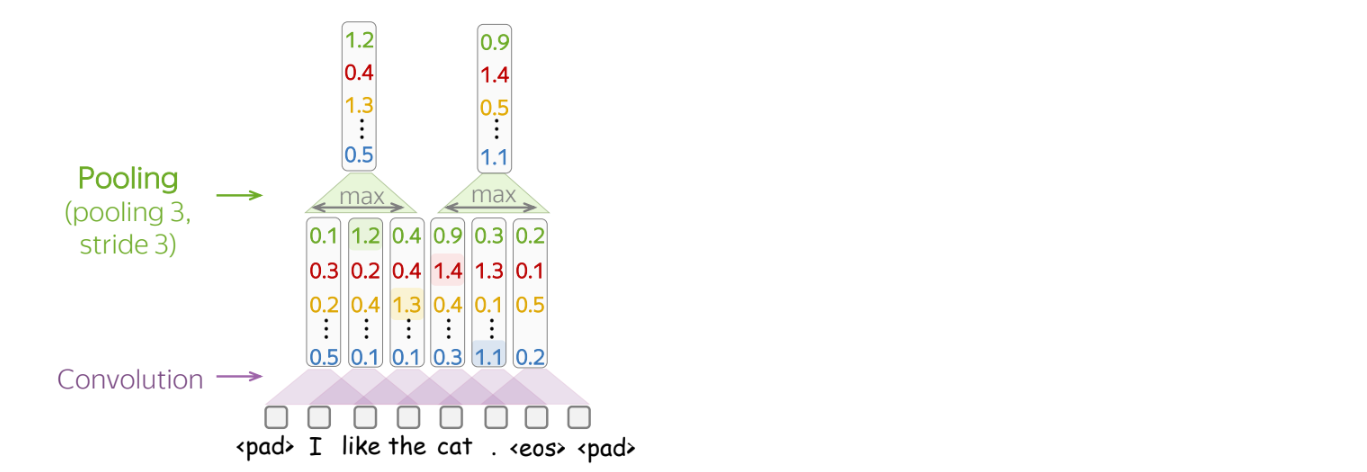

In [ ]:
max_pool = torch.max(conv_outs, dim=-1).values
max_pool.shape

torch.Size([3, 64])

### **Neural Network**

In [ ]:
import torch.nn as nn

In [ ]:
class SalaryPredictor(nn.Module):   # Inherit from nn.Module
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, 32)
        self.conv = nn.Conv1d(32, hid_size, kernel_size=3)
        self.fc = nn.Linear(n_cat_features, n_cat_features)
        self.model = nn.Sequential(
            nn.Linear(n_cat_features+128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, batch):
        emb_text_columns = torch.cat([torch.max(self.conv(self.emb(batch[column]).transpose(1, 2)), dim=-1).values for column in text_columns], axis=1)
        emb_categorical = self.fc(batch['Categorical'])
        input = torch.cat((emb_text_columns, emb_categorical), axis=1)
        output = self.model(input).reshape(1, -1)[0]
        return output

better to train **separate** conv for Title and Description:

```
title_enc = TitleEncoder()
descr_enc = DescripEncoder()
descr_enc.emd = title_enc.emb    # shared emb params between two encoders
```



In [ ]:
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data.

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [ ]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 5

In [ ]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [143]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(model, data_val, device=device)

epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.15765
Mean absolute error: 0.30461
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.12994
Mean absolute error: 0.27929
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.11473
Mean absolute error: 0.25846
epoch: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.11758
Mean absolute error: 0.26461
epoch: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.10564
Mean absolute error: 0.24612


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [144]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [145]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [146]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [150]:
i = 11177
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

film game sales assistant / sales advisor

film game sales assistant / sales advisor : media / film / game sales UNK , nottinghamshire unique client solutions is a marketing and sales company that helps companies increase their market share and brand awareness throughout the yorkshire nottinghamshire regions . we recently started a campaign for lovefilm and we need to grow quickly to keep up with their demand . we re looking to branch out into new markets before the end of the year , and we re currently planning our expansion to the netherlands in early 2013 , so there will be growth and travel opportunities too we currently have multiple openings in nottingham for people with above average sales or customer service skills that are interested in : marketing / brand management sales / account management customer service / client relations business development / management we acquire new customers for our client by meeting potential customers facetoface where they live so we can keep track of geographic and demographic statistics for our client . no sales experience is required because we offer daily producttraining workshops . previous experience involving customer interaction ( such as retail sales , customer service , waiting , bar work , etc .) can be beneficial , but we ' re simply looking for people that : are over 18 years of age and eligible to work in the uk can commute to nottingham city centre each day are driven to achieve success and willing to work hard have a positive attitude and enjoy speaking with customers want an opportunity to grow personally and professionally in an effort to find the right people to represent our clients and help expand our industry , we routinely invite people to spend a full day in the field observing our operations . the day is designed to help the decisionmaking process and participants do not receive compensation , but they get a chance to see if the opening is best for them . we operate in a performancebased industry and therefore growth opportunities and individual earnings will also be resultbased . please send your cv through the online application process for consideration . if your cv is successful , we will notify you straight away via email or phone , so please be sure your contact details are provided . thanks for your interest in unique client solutions . we look forward to hearing from you

In [148]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 194497
Salary (gbp): tensor([35117.5938])


net developer / c developer renowned online retailer perm london , **** k **** k

. net developer / c developer my client a very successful online retailer , is looking for a . net developer / c developer who is passionate about delivering successful it solutions and keen to cut their teeth in a large software development team . this is a great opportunity to join a growing and vibrant team in the fastpaced world of retail and ecommerce . experience as a . net developer / c developer experience in developing applications using microsoft . net is essential proven track record of commercial software development experience using microsoft . net and / c . net / asp . net knowledge of object orientated analysis and design , uml and design patterns . proven track record of commercial experience using sql server and tsql a good understanding of the principles of database design and the associated challenges . competent in the use of ms word , ms excel and visio . microsoft mvc experience is highly desirable asp . net experience responsibilities and duties as a . net developer / c developer interpret written business requirements and specification documents . perform coding specifications . investigate , analyse and document reported system defects perform maintenance programming and correction of identified system defects create , document , and implement unit test plans , scripts , and test harnesses . create and maintain technical documentation . engage in all aspects of the software development lifecycle in accordance with commercial requirements and organisational standards . establish and maintain detailed knowledge of business processes and associated software applications ( including those supplied by third parties ), tools , data feeds and application interfaces . perform project estimation , proofofconcept , testing , training , product rollout , and production support . report on progress and status as required to management and support maintenance of project plans . ensure project artifacts are complete and comprehensive , adhering to standards and guidelines for project management and delivery . good experience in asp . net this is a great opportunity for a . net developer / c developer to join a company passionate about technology . asp . net / c / sql . net developer / c developer click on the apply button to take advantage of this opportunity and for the next step in your career .

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)